In [ ]:
!pip install -U langchain==0.3.24 langchain-openai==0.3.14 langgraph==0.3.33 langchain-tavily==0.1.6

In [68]:
import os
os.environ["LANGCHAIN_API_KEY"] = ### Your-key
os.environ["LANGCHAIN_PROJECT"] = "Reasoning-Agent"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["TAVILY_API_KEY"] = ### Your-key
os.environ["OPENAI_API_KEY"] = ### Your-key

# **Refection Agent**

In [127]:
from langgraph.prebuilt import create_react_agent

def get_weather(city: str) -> str:
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"

agent = create_react_agent(
    model="gpt-4.1-nano",
    tools=[get_weather],
    prompt="You are a helpful assistant"
)

# Run the agent
agent.invoke(
    {"messages": [{"role": "user", "content": "what is the weather in Vietnam?"}]}
)

{'messages': [HumanMessage(content='what is the weather in Vietnam?', additional_kwargs={}, response_metadata={}, id='3a3de624-b9cf-4c13-9839-83137356c263'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OMX1ai4ju4DuDSY0q8MMajpv', 'function': {'arguments': '{"city":"Vietnam"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 57, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_eede8f0d45', 'id': 'chatcmpl-BVXJjhc8oGKRwttfM0pJmlveEifDY', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8adf8a68-0a99-4918-9b49-fa24fe65fbf3-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'Vietnam'}, 'id': 'call_OMX1ai4ju4DuDSY0q8MM

## **Generate**

In [32]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage
from langchain_openai import ChatOpenAI

generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a twitter techie influencer assistant tasked with writing excellent twitter posts."
            " Generate the best twitter post possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

llm = ChatOpenAI(model="gpt-4.1-nano")
generate_chain = generation_prompt | llm

In [33]:
request = HumanMessage(
    content="Write a twitter on why the little prince is relevant in modern childhood"
)
response = generate_chain.invoke({"messages": [request]})
response.content

'✨The Little Prince teaches timeless lessons: see with your heart, value genuine friendships, and nurture curiosity. In a world obsessed with screens, its message reminds kids (and adults) to cherish imagination & kindness. 🌟📖 #Childhood #TheLittlePrince #LifeLessons'

##Reflect

In [34]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a viral twitter influencer grading a tweet. Generate critique and recommendations for the user's tweet."
            "Always provide detailed recommendations, including requests for length, virality, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect_chain = reflection_prompt | llm

In [35]:
reflected_response = reflect_chain.invoke({"messages": [request, HumanMessage(content=response.content)]})
reflected_response.content

'Great start! You\'ve captured the essence of *The Little Prince* and connected it to modern childhood themes effectively. Here are some detailed recommendations to elevate your tweet for maximum impact and virality:\n\n1. **Length & Clarity:**  \n   - Current length is good, but to make it more punchy, consider condensing slightly. Twitter favors brevity, especially if you want more engagement.\n\n2. **Hook & Opening:**  \n   - Start with a compelling hook that instantly captures attention. For example, "Why is *The Little Prince* still a must-read for kids today?"\n\n3. **Emphasize Virality & Shareability:**  \n   - Incorporate a relatable or provocative question or statement to evoke emotional responses or curiosity.  \n   - For instance, referencing a common modern dilemma can spark connection: "In a world overwhelmed by screens, does *The Little Prince* hold the key to childhood innocence?"\n\n4. **Style & Tone:**  \n   - Use poetic or metaphorical language to match the whimsical 

## Repeat

In [36]:
reflected_response = reflect_chain.invoke({"messages": [request, AIMessage(content=response.content), HumanMessage(content=reflected_response.content)]})
reflected_response.content

'Absolutely, your initial tweet has a solid foundation! To maximize reach, consider making it more engaging and concise. Here are some specific suggestions:\n\n1. **Hook & Opening:**  \n   Start with a captivating question or statement to immediately grab attention. For example:  \n   *"Ever wonder why *The Little Prince* still resonates with kids today?"*\n\n2. **Length & Clarity:**  \n   Keep your message tight—about 2-3 lines—so it\'s easily retweeted and appreciated. Use punchy language that emphasizes the core message about timeless lessons and relevance.\n\n3. **Virality & Shareability:**  \n   Incorporate an emotional or provocative element. Asking a question at the end encourages replies and interaction.\n\n4. **Tone & Style:**  \n   Use poetic or evocative language consistent with the book\'s whimsical tone. Emojis can add visual appeal but should be used sparingly.\n\n5. **Hashtags & Engagement:**  \n   Use targeted hashtags to increase visibility and invite sharing with a ca

## **Graph**

In [41]:
from typing import List, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph import END, MessageGraph

REFLECT = "reflect"
GENERATE = "generate"


def generation_node(state: Sequence[BaseMessage]):
    return generate_chain.invoke({"messages": state})


def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    res = reflect_chain.invoke({"messages": messages})
    return [HumanMessage(content=res.content)]


builder = MessageGraph()
builder.add_node(GENERATE, generation_node)
builder.add_node(REFLECT, reflection_node)
builder.set_entry_point(GENERATE)


def should_continue(state: List[BaseMessage]):
    if len(state) > 6:
        return END
    return REFLECT


builder.add_conditional_edges("generate", should_continue, {END:END, "reflect":"reflect"})
builder.add_edge(REFLECT, GENERATE)
graph = builder.compile()
graph.get_graph().draw_mermaid_png(output_file_path="graph.png")
graph.get_graph().print_ascii()

          +-----------+            
          | __start__ |            
          +-----------+            
                *                  
                *                  
                *                  
          +----------+             
          | generate |             
          +----------+             
          ...        ***           
         .              *          
       ..                **        
+---------+           +---------+  
| __end__ |           | reflect |  
+---------+           +---------+  


In [42]:
request = HumanMessage(
    content="Write a twitter on why the little prince is relevant in modern childhood"
)
response = graph.invoke(request)
response

[HumanMessage(content='Write a twitter on why the little prince is relevant in modern childhood', additional_kwargs={}, response_metadata={}, id='436e2c31-6d88-4ee2-8c29-14b36fd4514e'),
 AIMessage(content='🌟 The Little Prince reminds us that curiosity, kindness, and imagination are timeless virtues. In a world dominated by screens, his lessons on seeing with the heart help children understand what truly matters—love, friendship, and wonder. #Childhood #TimelessStories #TheLittlePrince', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 66, 'total_tokens': 124, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_8fd43718b3', 'id': 'chatcmpl-BVKxl7HRR9ypuiGdhxrjuuVxBiIr5', 'service_tier': 'default', 'finish_

# **ReAct Agent**

## **State**

In [7]:
from typing import Annotated,Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    number_of_steps: int

## **Tools**

In [52]:
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

@tool
def triple(num: float) -> float:
    """
    :param num: a number to triple
    :return: the number tripled ->  multiplied by 3
    """
    return 3 * float(num)


tools = [TavilySearch(max_results=1), triple]

In [74]:
model = ChatOpenAI(model="gpt-4.1-nano")

## **Agent**

In [53]:
from langchain_core.messages import SystemMessage

system_prompt = SystemMessage(
"""
You are a reasoning agent. Always think step-by-step.

Use the following format:

Thought: what you are thinking
Action: the action to take, e.g. `search`, `calculate`
Action Input: the input to the action
Observation: the result of the action

(Repeat Thought/Action/Observation if needed)

Final Answer: your answer to the user

Question: {input}
"""
)

In [54]:
import json
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}


# Define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# Define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

## **Graph**

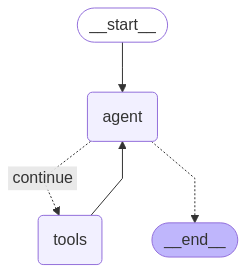

In [55]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [56]:
# Create our initial message dictionary
inputs = {"messages": [("user", "How is the weather in Vietnam?")]}

# call our graph with streaming to see the steps

for state in graph.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

How is the weather in Vietnam?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_WaES3NHGYhmpEnQtJgr3IKjy)
 Call ID: call_WaES3NHGYhmpEnQtJgr3IKjy
  Args:
    query: current weather in Vietnam
    search_depth: basic
================================= Tool Message =================================
Name: tavily_search

{"query": "current weather in Vietnam", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Weather in Vietnam", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Hanoi', 'region': '', 'country': 'Vietnam', 'lat': 21.033, 'lon': 105.85, 'tz_id': 'Asia/Bangkok', 'localtime_epoch': 1746844794, 'localtime': '2025-05-10 09:39'}, 'current': {'last_updated_epoch': 1746844200, 'last_updated': '2025-05-10 09:30', 'temp_c': 28.2, 'temp_f': 82.8, 'is_day': 1, 'condition': {'text': 'Part

In [57]:
inputs = {"messages": [("user", "what is the weather in vietnam? Then Triple it ")]}

for state in graph.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

what is the weather in vietnam? Then Triple it 
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_gN7sBfV4GynshBpXRt04V6xO)
 Call ID: call_gN7sBfV4GynshBpXRt04V6xO
  Args:
    query: current weather in Vietnam
    search_depth: basic
================================= Tool Message =================================
Name: tavily_search

{"query": "current weather in Vietnam", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Weather in Vietnam", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Hanoi', 'region': '', 'country': 'Vietnam', 'lat': 21.033, 'lon': 105.85, 'tz_id': 'Asia/Bangkok', 'localtime_epoch': 1746844794, 'localtime': '2025-05-10 09:39'}, 'current': {'last_updated_epoch': 1746844200, 'last_updated': '2025-05-10 09:30', 'temp_c': 28.2, 'temp_f': 82.8, 'is_day': 1, 'condition

# **Plan-and-Execute Agent**

## **State**

In [117]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

## **Tools**

In [113]:
from langchain_tavily import TavilySearch

tools = [TavilySearch(max_results=1)]

In [115]:
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o")
prompt = "You are a helpful assistant."
agent_executor = create_react_agent(llm, tools, prompt=prompt)

In [116]:
agent_executor.invoke({"messages": [("user", "How is the weather in Vietnam?")]})

{'messages': [HumanMessage(content='How is the weather in Vietnam?', additional_kwargs={}, response_metadata={}, id='b3ac6802-278f-47fc-bdf9-6cf34e4e8634'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_znuHSbApKzKUnPXEvE2PVw1Z', 'function': {'arguments': '{"query":"Vietnam current weather","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 780, 'total_tokens': 803, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BVVFWOI0X29I43g5aBcLniLJdRILb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ab4f852f-cbf6-4664-ae02-e603c85f3422-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Vietnam 

## **Planner**

In [118]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan)

planner.invoke(
    {
        "messages": [
            ("user", "What is the weather in Vietnam?")
        ]
    }
)

Plan(steps=['Open a web browser on your device.', 'Go to a reliable weather website such as weather.com or BBC Weather.', "In the search bar, type 'Vietnam' and press enter.", 'Look for the current weather information displayed for Vietnam, including temperature, weather conditions (e.g., sunny, rainy), and any other relevant details.', 'Note down the weather information provided for Vietnam.'])

## **Excutor**

In [119]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

## **Graph**

In [120]:
from typing import Literal
from langgraph.graph import END

async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
        {plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [121]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

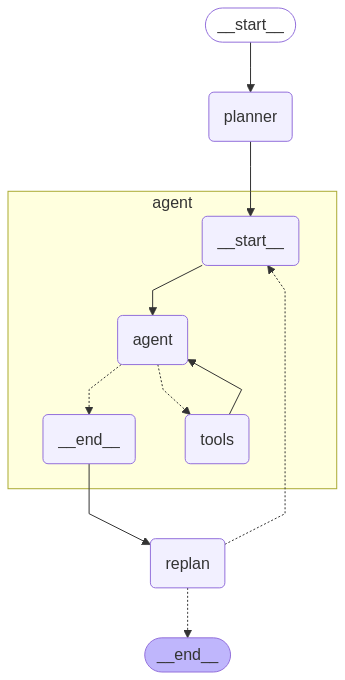

In [122]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [126]:
config = {"recursion_limit": 50}
inputs = {"input": "Solve for all real solutions x to the equation: sqrt(x -2) = 3"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Start with the equation: sqrt(x - 2) = 3.', 'Square both sides of the equation to eliminate the square root: (sqrt(x - 2))^2 = 3^2.', 'Simplify both sides: x - 2 = 9.', 'Add 2 to both sides to solve for x: x = 9 + 2.', 'Simplify the right side: x = 11.', 'Verify the solution by substituting x = 11 back into the original equation: sqrt(11 - 2) = 3.', 'Simplify the left side: sqrt(9) = 3.', 'Since both sides are equal, x = 11 is a valid solution.']}
{'past_steps': [('Start with the equation: sqrt(x - 2) = 3.', 'Step 1 has already been specified in the plan. The equation given is:\n\n\\[\n\\sqrt{x - 2} = 3\n\\]\n\nThis is the starting point for solving the equation and verifying the solution in subsequent steps.')]}
{'plan': ['Square both sides of the equation to eliminate the square root: (sqrt(x - 2))^2 = 3^2.', 'Simplify both sides: x - 2 = 9.', 'Add 2 to both sides to solve for x: x = 9 + 2.', 'Simplify the right side: x = 11.', 'Verify the solution by substituting x = 11 b

In [125]:
config = {"recursion_limit": 50}
inputs = {"input": "Solve for all real solutions x to the equation: sqrt(x + sqrt(2x + 7)) = 3"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Start with the equation: sqrt(x + sqrt(2x + 7)) = 3.', 'Square both sides of the equation to eliminate the outer square root: x + sqrt(2x + 7) = 9.', 'Isolate the inner square root by subtracting x from both sides: sqrt(2x + 7) = 9 - x.', 'Square both sides again to eliminate the square root: 2x + 7 = (9 - x)^2.', 'Expand the right side: 2x + 7 = 81 - 18x + x^2.', 'Rearrange the equation to form a quadratic equation: x^2 - 20x + 74 = 0.', 'Use the quadratic formula to solve for x: x = [20 ± sqrt((20)^2 - 4*1*74)] / 2*1.', 'Calculate the discriminant: (20)^2 - 4*1*74 = 400 - 296 = 104.', 'Calculate the square root of the discriminant: sqrt(104) = 2*sqrt(26).', 'Substitute back into the quadratic formula: x = [20 ± 2*sqrt(26)] / 2.', 'Simplify the solutions: x = 10 ± sqrt(26).', 'Verify each solution by substituting back into the original equation to ensure they are valid real solutions.', 'The real solutions are x = 10 + sqrt(26) and x = 10 - sqrt(26).']}
{'past_steps': [('St